# Differential Privacy <> TensorFlow for Data Scientist Salaries
https://www.tensorflow.org/responsible_ai/privacy/tutorials/classification_privacy

## Setup Packages

### Install TensorFlow

In [2]:
!pip install tensorflow
!pip install tensorflow-privacy

In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import numpy as np

tf.get_logger().setLevel('ERROR')

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

Instructions for updating:
non-resource variables are not supported in the long term


### Install Other Libraries

In [4]:
import datetime
from datetime import datetime

from numpy.random import RandomState
import pandas as pd
from sklearn import preprocessing


## Setup Data

### Categorize Salaries

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,9/9/2018 11:52:32,Google,T4,Software Engineer,327000,"Seattle, WA",10.0,1.0,Distributed Systems (Back-End),155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62638,9/13/2018 8:23:32,Microsoft,62,Software Engineer,237000,"Redmond, WA",2.0,2.0,Full Stack,146900.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62639,9/13/2018 14:35:59,MSFT,63,Software Engineer,220000,"Seattle, WA",14.0,12.0,Full Stack,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
62640,9/16/2018 16:10:35,Salesforce,Lead MTS,Software Engineer,280000,"San Francisco, CA",8.0,4.0,iOS,194688.0,...,0,0,0,0,0,0,0,0,NaN,NaN


<AxesSubplot:>

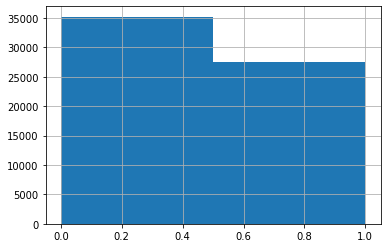

In [162]:
df = pd.read_csv('salaries.csv')
display(df)

salary_ranges = [0,200000,np.inf]
df['salaryrange'] = pd.cut(df.totalyearlycompensation, salary_ranges, labels=[0,1], include_lowest=True)

df['salaryrange'].hist(bins=len(salary_ranges) - 1)

In [179]:
df.salaryrange.value_counts()

0    11575
1     7175
Name: salaryrange, dtype: int64

### Drop Columns

In [164]:
# location information is already encoded as an integer in 'cityid'
df.drop('location', axis=1, inplace=True)

# make model predict without knowledge of the base salary
df.drop('basesalary', axis=1, inplace=True)

# 'otherdetails' column requires NLP to interpret
df.drop('otherdetails', axis=1, inplace=True)

# 'rowNumber' column is unnecessary
df.drop('rowNumber', axis=1, inplace=True)

# education information is entirely encoded in the 'Education' column already
df.drop('Masters_Degree', axis=1, inplace=True)
df.drop('Bachelors_Degree', axis=1, inplace=True)
df.drop('Doctorate_Degree', axis=1, inplace=True)
df.drop('Highschool', axis=1, inplace=True)
df.drop('Some_College', axis=1, inplace=True)

# race information is entirely encoded in the 'Race' column already
df.drop('Race_Asian', axis=1, inplace=True)
df.drop('Race_White', axis=1, inplace=True)
df.drop('Race_Two_Or_More', axis=1, inplace=True)
df.drop('Race_Black', axis=1, inplace=True)
df.drop('Race_Hispanic', axis=1, inplace=True)

### Make All Values Into Integers

In [165]:
# encode timestamp into integers, by year and month
def timestamp_to_int(timestamp):
    dt_obj = datetime.strptime(timestamp.split(' ')[0], '%m/%d/%Y')
    return (100 * dt_obj.year) + (dt_obj.month)

df['timestamp'] = df['timestamp'].apply(timestamp_to_int)

# turn company names to lowercase and encode as integers
df['company'] = df['company'].apply(lambda t: str(t).lower())
df['company'] = pd.Categorical(pd.factorize(df['company'])[0])

# encode level as integer
df['level'] = pd.Categorical(pd.factorize(df['level'])[0])

# encode title as integer
df['title'] = pd.Categorical(pd.factorize(df['title'])[0])

# encode tag as integer
df['tag'] = pd.Categorical(pd.factorize(df['tag'])[0])

# encode gender as integer
df['gender'] = pd.Categorical(pd.factorize(df['gender'])[0])

# encode Race as integer
df['Race'] = pd.Categorical(pd.factorize(df['Race'])[0])

# encode Education as integer
df['Education'] = pd.Categorical(pd.factorize(df['Education'])[0])


### Remove Rows

In [166]:
df = df[df['gender'] != -1]
df = df[df['Education'] != -1]
df = df[df['Race'] != -1]
df = df[(50000 < df['totalyearlycompensation']) & (df['totalyearlycompensation'] < 500000)]

### Training/Testing Data

In [173]:
drop_indices = np.random.choice(df.index, len(df.index) % 1250, replace=False)
df.drop(drop_indices, inplace=True)

rng = RandomState()

df_train = df.sample(frac=0.8, random_state=rng)
df_test = df.loc[~df.index.isin(df_train.index)]

print('Whole Dataset')
display(df)
print('Training Dataset')
display(df_train)
print('Testing Dataset')
display(df_test)

Whole Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
15710,202001,9,11,1,400000,5.0,5.0,1,145000.0,45000.0,0,7472,807.0,1,0,1
23532,202007,4,46,1,136000,3.0,2.0,4,1000.0,11000.0,0,11521,819.0,3,2,0
23533,202007,9,12,1,337000,6.0,6.0,0,125000.0,36000.0,0,7413,807.0,1,2,1
23534,202007,4,7,1,222000,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,1
23535,202007,807,62,1,187000,5.0,0.0,0,22000.0,0.0,0,7419,807.0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61824,202108,790,1410,1,77000,0.0,0.0,1,0.0,15000.0,0,41795,0.0,1,2,0
61826,202108,449,133,1,92000,2.0,2.0,0,0.0,0.0,0,7839,524.0,1,2,0
61828,202108,806,131,1,95000,3.0,3.0,1,0.0,5000.0,0,35382,521.0,0,2,0
61830,202108,2,11,0,241000,9.0,0.0,1464,46000.0,45000.0,1,11527,819.0,1,2,1


Training Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
54530,202106,426,73,0,228000,11.0,10.0,36,12000.0,0.0,0,11109,618.0,0,1,1
24522,202007,4,46,1,187000,3.0,0.0,1,30000.0,20000.0,0,11521,819.0,1,1,0
34768,202011,625,15,1,66000,12.0,12.0,2,14000.0,2000.0,0,4058,0.0,1,1,0
30623,202009,2,12,0,79000,4.0,2.0,202,15000.0,0.0,1,3722,0.0,1,1,0
49235,202104,57,1031,1,300000,15.0,7.0,902,115000.0,3000.0,0,7369,807.0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59889,202108,16,167,1,185000,13.0,7.0,52,20000.0,20000.0,0,10522,820.0,1,1,0
48721,202104,54,271,0,136000,4.0,4.0,1458,0.0,11000.0,0,11039,623.0,1,2,0
37515,202012,1003,17,0,152000,3.0,3.0,36,20000.0,17000.0,0,8909,512.0,2,1,0
43323,202102,6,17,1,255000,2.0,2.0,0,58000.0,23000.0,0,7300,807.0,3,2,1


Testing Dataset


,timestamp,company,level,title,totalyearlycompensation,yearsofexperience,yearsatcompany,tag,stockgrantvalue,bonus,gender,cityid,dmaid,Race,Education,salaryrange
23534,202007,4,7,1,222000,4.0,4.0,3,38000.0,20000.0,0,11527,819.0,1,1,1
23548,202007,2,15,1,142000,0.0,0.0,0,4000.0,26000.0,0,7053,753.0,1,1,0
23555,202007,4,7,1,173000,10.0,2.0,7,9000.0,10000.0,0,11521,819.0,1,2,0
23557,202007,388,359,1,121000,9.0,4.0,4,0.0,10000.0,0,10965,635.0,4,1,0
23558,202007,4,16,1,328000,12.0,0.0,1280,63000.0,50000.0,0,7419,807.0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61783,202108,9,12,7,260000,5.0,3.0,1704,60000.0,30000.0,1,7275,803.0,0,2,1
61793,202108,583,155,3,120000,1.0,0.0,54,0.0,10000.0,0,10522,820.0,0,1,0
61807,202108,629,0,1,171000,5.0,3.0,3,10000.0,10000.0,0,11496,819.0,3,2,0
61810,202108,2,206,1,157000,0.0,0.0,0,22000.0,15000.0,0,11527,819.0,1,1,0


In [174]:
train_data = df_train.loc[:, df_train.columns != 'salaryrange'].to_numpy()
test_data = df_test.loc[:, df_test.columns != 'salaryrange'].to_numpy()

train_labels = df_train['salaryrange'].to_numpy()
test_labels = df_test['salaryrange'].to_numpy()

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(salary_ranges) - 1)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(salary_ranges) - 1)

## Make the Model

### Set Variables

In [175]:
epochs = 3
batch_size = 250

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

### Add Layers to Model

In [176]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(salary_ranges) - 1)
])

In [180]:

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

In [181]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.build(train_data.shape)
model.summary()
model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            multiple                  512       
                                                                 
 dense_55 (Dense)            multiple                  66        
                                                                 
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 3750 samples
Epoch 1/3
15000/15000 [==============================] - 18s 1ms/sample - loss: 1393.3702 - acc: 0.8881 - val_loss: 507.6131 - val_acc: 0.9224
Epoch 2/3
15000/15000 [==============================] - 0s 20us/sample - loss: 264.5858 - acc: 0.9457 - val_loss: 246.6771 - val_acc: 0.9456
Epoch 3/3
15000/15000 [==============================] - 0s 25us/sample - loss: 165.8573 - acc: 0.9580 - val_loss: 20

In [127]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.5% and noise_multiplier = 1.1 iterated over 600 steps satisfies differential privacy with eps = 0.871 and delta = 1e-05.
The optimal RDP order is 12.0.


(0.8713848887473219, 12.0)